In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

import bk.load
import bk.compute
import bk.signal

In [3]:
session_paths=['Z:\\Rat08\\Rat08-20130708',
 'Z:\\Rat08\\Rat08-20130709',
 'Z:\\Rat08\\Rat08-20130710',
 'Z:\\Rat08\\Rat08-20130711',
 'Z:\\Rat08\\Rat08-20130712',
 'Z:\\Rat08\\Rat08-20130713',
 'Z:\\Rat08\\Rat08-20130715',
 'Z:\\Rat08\\Rat08-20130716',
 'Z:\\Rat08\\Rat08-20130717',
 'Z:\\Rat08\\Rat08-20130718',
 'Z:\\Rat08\\Rat08-20130719',
 'Z:\\Rat09\\Rat09-20140324',
 'Z:\\Rat09\\Rat09-20140325',
 'Z:\\Rat09\\Rat09-20140326',
 'Z:\\Rat09\\Rat09-20140327',
 'Z:\\Rat09\\Rat09-20140328',
 'Z:\\Rat09\\Rat09-20140329',
 'Z:\\Rat09\\Rat09-20140331',
 'Z:\\Rat09\\Rat09-20140401',
 'Z:\\Rat09\\Rat09-20140402',
 'Z:\\Rat09\\Rat09-20140403',
 'Z:\\Rat09\\Rat09-20140404',
 'Z:\\Rat09\\Rat09-20140405',
 'Z:\\Rat09\\Rat09-20140407',
 'Z:\\Rat09\\Rat09-20140408',
 'Z:\\Rat09\\Rat09-20140409',
 'Z:\\Rat10\\Rat10-20140619',
 'Z:\\Rat10\\Rat10-20140620',
 'Z:\\Rat10\\Rat10-20140622',
 'Z:\\Rat10\\Rat10-20140624',
 'Z:\\Rat10\\Rat10-20140626',
 'Z:\\Rat10\\Rat10-20140627',
 'Z:\\Rat10\\Rat10-20140628',
 'Z:\\Rat10\\Rat10-20140629',
 'Z:\\Rat10\\Rat10-20140701',
 'Z:\\Rat10\\Rat10-20140702',
 'Z:\\Rat10\\Rat10-20140703',
 'Z:\\Rat10\\Rat10-20140704',
 'Z:\\Rat10\\Rat10-20140705',
 'Z:\\Rat10\\Rat10-20140707',
 'Z:\\Rat10\\Rat10-20140708',
 'Z:\\Rat11\\Rat11-20150310',
 'Z:\\Rat11\\Rat11-20150312',
 'Z:\\Rat11\\Rat11-20150313',
 'Z:\\Rat11\\Rat11-20150314',
 'Z:\\Rat11\\Rat11-20150315',
 'Z:\\Rat11\\Rat11-20150316',
 'Z:\\Rat11\\Rat11-20150317',
 'Z:\\Rat11\\Rat11-20150321',
 'Z:\\Rat11\\Rat11-20150323',
 'Z:\\Rat11\\Rat11-20150325',
 'Z:\\Rat11\\Rat11-20150326',
 'Z:\\Rat11\\Rat11-20150328',
 'Z:\\Rat11\\Rat11-20150330',
 'Z:\\Rat11\\Rat11-20150331',
 'Z:\\Rat11\\Rat11-20150401',
 'Z:\\Rat11\\Rat11-20150402',
 'Z:\\Rat11\\Rat11-20150403']

'Z:\\Rat11\\Rat11-20150403'

In [4]:
#load data and split neurons in the selected region by type
def split_neurons_types_regions(path, brain_region):
    bk.load.current_session(path)
    neurons, metadata = bk.load.loadSpikeData(path)
    pyramidal = neurons[(metadata['Type']=='Pyr') & (metadata['Region']==brain_region)]
    interneurons = neurons[(metadata['Type']=='Int') & (metadata['Region']==brain_region)]
    other_neurons = neurons[metadata['Type']=='Unk']
    return pyramidal, interneurons, other_neurons

In [6]:
def get_firing_rate_for_specific_state(neurons, state):
    """
    Returns a pandas Series object with the mean firing rate of each of the neurons during a chosen state (REM, sws, drowsy, or wake)
    
    Keyword arguments:
    neurons -- numpy.ndarray containing series data of selected neurons 
    state -- string, should be one of the following: Rem, sws, drowsy, wake (default='REM')
    
    Restrictions:
    Can only be called when the neurons and session have already been loaded.
    """
    mean_firing_rates = pd.Series(index = np.arange(len(neurons)),dtype='float64')
    state_used = bk.load.states()[state]

    for i in range(len(neurons)):
        try:
            spk_time = neurons[i].restrict(state_used).as_units('ms').index.values
            mean_firing_rates[i] = len(spk_time)/state_used.tot_length('s')
        except Exception:
            pass #using this exeption because not all neurons have spikes in all states. The nan values cannot be used to calculate firing rates.
#     mean_firing_rates=mean_firing_rates.dropna()
    return mean_firing_rates

In [8]:
# #delete not needed
# #firing rate of cells during a given time
# def get_firing_rate_for_all_states(neurons):
    
#     states= bk.load.states()
#     possible_states=list(states.keys())
#     mean_firing_rates = pd.DataFrame(index = np.arange(len(neurons)),columns=possible_states, dtype='float64')
    
#     for state in possible_states:
#         state_used=states[state]
#         for i in range(len(neurons)):
#             spk_time = neurons[i].restrict(states[state_used]).as_units('ms').index.values
#             mean_firing_rates[state][i] = len(spk_time)/state_used.tot_length('s')

#     return mean_firing_rates 

In [10]:
def get_FR_per_state_neurontype(path, states, brain_region):
    '''
    Returns 2 lists (one for each state) with the mean firing rate of each of the types of neurons (Pyramidal, interneurons, unknown) during the chosen state.
    
    Keyword arguments:
    path -- string containing the dircetory where the data files are stored
    states -- list of 2 strings, should be one of the following: REM, sws, drowsy, wake (default='REM')
    '''
    neurons_by_type=split_neurons_types_regions(path, brain_region)
    firing_rates_state0=[]
    firing_rates_state1=[]
    for i in neurons_by_type:
        x=get_firing_rate_for_specific_state(i, states[0])
        y=get_firing_rate_for_specific_state(i, states[1])
        firing_rates_state0.append(x)
        firing_rates_state1.append(y)
    return firing_rates_state0, firing_rates_state1

In [12]:
def get_plot_c_all_sessions(paths, states, brain_region):
    '''
    Returns N lists (one for each state) with the mean firing rate of each of the types of neurons (Pyramidal, interneurons, unknown) during the chosen state
    where N is the number of sessions.
    Returned lists structure = Number of sessions * number of types of cells(=3) * number of cells(depends on session)
    
    Keyword arguments:
    paths -- list of strings containing the dircetories where the data files for each sessions are stored
    states -- list of 2 strings, should be one of the following: REM, sws, drowsy, wake (default='REM')
    '''
    
    all_sessions_state0=[]
    all_sessions_state1=[]

    for path in paths:
        FR_per_cell_state0,FR_per_cell_state1=get_FR_per_state_neurontype(path, states, brain_region)
        all_sessions_state0.append(FR_per_cell_state0)
        all_sessions_state1.append(FR_per_cell_state1)
    return all_sessions_state0, all_sessions_state1

In [16]:
def get_scatter_plot(paths, states, brain_region):
    x,y=get_plot_c_all_sessions(paths, states, brain_region)
    identity=np.linspace(-10,100,101) 
    plt.plot(identity,identity, 'k-', color='b')
    for i in range(len(x)):
        plt.scatter(x[i][2],y[i][2], color='gray')
        plt.scatter(x[i][0],y[i][0], color='r')
        plt.scatter(x[i][1],y[i][1], color='b')
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel(f'{states[0]} rate (Hz)')
    plt.ylabel(f'{states[1]} rate (Hz)')
    plt.show()

Rat : 8 on day : 1
Working with session Rat08-20130708 @ Z:\Rat08\Rat08-20130708
Data already saved in Numpy format, loading them from here:
Rat08-20130708-neurons.npy
Rat08-20130708-metadata.npy
Rat : 8 on day : 2
Working with session Rat08-20130709 @ Z:\Rat08\Rat08-20130709
Data already saved in Numpy format, loading them from here:
Rat08-20130709-neurons.npy
Rat08-20130709-metadata.npy
Rat : 8 on day : 3
Working with session Rat08-20130710 @ Z:\Rat08\Rat08-20130710
Data already saved in Numpy format, loading them from here:
Rat08-20130710-neurons.npy
Rat08-20130710-metadata.npy
Rat : 8 on day : 4
Working with session Rat08-20130711 @ Z:\Rat08\Rat08-20130711
Data already saved in Numpy format, loading them from here:
Rat08-20130711-neurons.npy
Rat08-20130711-metadata.npy
Rat : 8 on day : 5
Working with session Rat08-20130712 @ Z:\Rat08\Rat08-20130712
Data already saved in Numpy format, loading them from here:
Rat08-20130712-neurons.npy
Rat08-20130712-metadata.npy
Rat : 8 on day : 6
W

Rat11-20150310-metadata.npy
Rat : 11 on day : 3
Working with session Rat11-20150312 @ Z:\Rat11\Rat11-20150312
Data already saved in Numpy format, loading them from here:
Rat11-20150312-neurons.npy
Rat11-20150312-metadata.npy
Rat : 11 on day : 4
Working with session Rat11-20150313 @ Z:\Rat11\Rat11-20150313
Data already saved in Numpy format, loading them from here:
Rat11-20150313-neurons.npy
Rat11-20150313-metadata.npy
Rat : 11 on day : 5
Working with session Rat11-20150314 @ Z:\Rat11\Rat11-20150314
Data already saved in Numpy format, loading them from here:
Rat11-20150314-neurons.npy
Rat11-20150314-metadata.npy
Rat : 11 on day : 6
Working with session Rat11-20150315 @ Z:\Rat11\Rat11-20150315
Data already saved in Numpy format, loading them from here:
Rat11-20150315-neurons.npy
Rat11-20150315-metadata.npy
Rat : 11 on day : 7
Working with session Rat11-20150316 @ Z:\Rat11\Rat11-20150316
Data already saved in Numpy format, loading them from here:
Rat11-20150316-neurons.npy
Rat11-20150316-

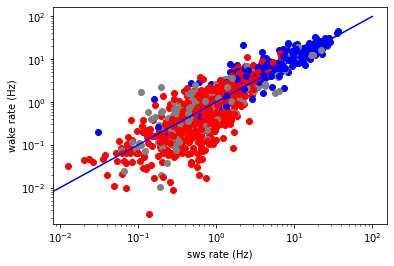

In [15]:
h=get_scatter_plot(session_paths, ['sws','wake'], 'BLA')